In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
df = pd.read_csv('./Data/Processed/cleaned_nse.csv')
df.head()

,Date,Stock_code,Name,12m Low,12m High,Day Low,Day High,Day Price,Previous,Change,%Change,Volume,Adjusted Price,Sector,Month,Year
0,2021-01-04,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.42,9.80,9.52,9.66,-0.14,1.45,18500.0,0.0,Banking,1,2021
1,2021-01-05,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.70,9.44,9.52,-0.08,0.84,1923300.0,0.0,Banking,1,2021
2,2021-01-06,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.40,9.68,9.44,9.44,0.00,0.00,233400.0,0.0,Banking,1,2021
3,2021-01-07,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.36,9.46,9.40,9.44,-0.04,0.42,194700.0,0.0,Banking,1,2021
4,2021-01-11,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.70,9.46,9.48,-0.02,0.21,77900.0,0.0,Banking,1,2021


In [37]:
# Feature Engineering Functions 

# Calculate daily returns for a stock.

def calculate_returns(group):
    group = group.sort_values('Date').copy()
    group['daily_return'] = group['Day Price'].pct_change()
    return group

# Calculating rolling volatility metrics.
def calculate_volatility_features(group, windows=[7, 14, 30]):
    group = group.sort_values('Date').copy()
    
    for window in windows:
        group[f'volatility_{window}d'] = group['daily_return'].rolling(
            window=window, min_periods=max(3, window//2)
        ).std()
    
    return group

# Calculate liquidity-related features.
def calculate_liquidity_features(group):
    
    group = group.sort_values('Date').copy()
    
    group['avg_volume'] = group['Volume'].rolling(window=30, min_periods=10).mean()
    group['volume_volatility'] = group['Volume'].rolling(window=30, min_periods=10).std()
    group['zero_volume_days'] = group['Volume'].rolling(window=30, min_periods=10).apply(
        lambda x: (x == 0).sum() if x.notna().sum() > 0 else np.nan
    )
    
    return group

# Calculating momentum and trend indicators.
def calculate_momentum_features(group):
    group = group.sort_values('Date').copy()
    
    group['momentum_30d'] = group['Day Price'].pct_change(periods=30)
    group['ma_7'] = group['Day Price'].rolling(window=7, min_periods=3).mean()
    group['ma_30'] = group['Day Price'].rolling(window=30, min_periods=10).mean()
    group['price_to_ma30'] = (group['Day Price'] - group['ma_30']) / group['ma_30']
    
    return group

# Calculate maximum drawdown.
def calculate_drawdown(group):
    group = group.sort_values('Date').copy()
    
    running_max = group['Day Price'].expanding().max()
    drawdown = (group['Day Price'] - running_max) / running_max
    
    group['current_drawdown'] = drawdown
    group['max_drawdown'] = group['current_drawdown'].expanding().min()
    
    return group

# Aggregate features at stock level.
def aggregate_stock_features(group):
    
    active_days = group[(group['Volume'].notna()) & (group['Volume'] > 0)]
    
    if len(active_days) < 20:
        return None
    
    features = {
        'Stock_code': group['Stock_code'].iloc[0],
        'Sector': group['Sector'].iloc[0] if 'Sector' in group.columns else None,
        'Name': group['Name'].iloc[0] if 'Name' in group.columns else None,
        
        'trading_days': len(active_days),
        'total_days': len(group),
        'trading_frequency': len(active_days) / len(group),
        
        'mean_return': active_days['daily_return'].mean(),
        'std_return': active_days['daily_return'].std(),
        
        'volatility_7d': group['volatility_7d'].mean() if 'volatility_7d' in group.columns else 0,
        'volatility_30d': group['volatility_30d'].mean() if 'volatility_30d' in group.columns else 0,
        
        'max_drawdown': group['max_drawdown'].min() if 'max_drawdown' in group.columns else 0,
        
        'avg_volume': active_days['Volume'].mean(),
        'zero_volume_ratio': (group['Volume'] == 0).sum() / len(group),
        
        'momentum_30d': group['momentum_30d'].iloc[-1] if 'momentum_30d' in group.columns else 0,
        'current_price': group['Day Price'].iloc[-1]
    }
    
    return features

In [38]:
# Applying feature engineering to df

print("Calculating returns")
df = df.groupby('Stock_code', group_keys=False).apply(calculate_returns).reset_index(drop=True)

print("Calculating volatility")
df = df.groupby('Stock_code', group_keys=False).apply(calculate_volatility_features).reset_index(drop=True)

print("Calculating liquidity")
df = df.groupby('Stock_code', group_keys=False).apply(calculate_liquidity_features).reset_index(drop=True)

print("Calculating momentum")
df = df.groupby('Stock_code', group_keys=False).apply(calculate_momentum_features).reset_index(drop=True)

print("Calculating drawdown...")
df = df.groupby('Stock_code', group_keys=False).apply(calculate_drawdown).reset_index(drop=True)

print("\nAggregating to stock level")
features_list = []
for Stock_code, group in df.groupby('Stock_code'):
    stock_features = aggregate_stock_features(group)
    if stock_features is not None:
        features_list.append(stock_features)

df_features = pd.DataFrame(features_list)

df_features.head()

Calculating returns
Calculating volatility
Calculating liquidity
Calculating momentum
Calculating drawdown...

Aggregating to stock level


,Stock_code,Sector,Name,trading_days,total_days,trading_frequency,mean_return,std_return,volatility_7d,volatility_30d,max_drawdown,avg_volume,zero_volume_ratio,momentum_30d,current_price
0,ABSA,Banking,ABSA Bank Kenya Plc,988,988,1.000000,0.000743,0.013638,0.011135,0.012541,-0.236220,457918.016194,0.000000,0.160772,18.05
1,BAMB,Construction and Allied,Bamburi Cement Ltd,974,988,0.985830,0.000901,0.028007,0.021978,0.024157,-0.514563,233655.667351,0.014170,-0.176030,55.00
2,BAT,Manufacturing and Allied,British American Tobacco Kenya Plc,936,988,0.947368,0.000126,0.013762,0.010576,0.012213,-0.348232,19173.611111,0.052632,0.059155,376.00
3,BKG,Banking,BK Group Plc,592,988,0.599190,0.001923,0.038372,0.025778,0.028502,-0.392500,86221.114865,0.400810,-0.012140,32.55
4,BOC,Manufacturing and Allied,BOC Kenya Plc,402,988,0.406883,0.001758,0.042706,0.021544,0.026053,-0.302949,10246.268657,0.593117,-0.002809,88.75


In [39]:
features = [
    "trading_frequency",
    "avg_volume",
    "zero_volume_ratio"
]

X = df_features[features]


In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

clusters = kmeans.fit_predict(X_scaled)

df_features["liquidity_cluster"] = clusters

In [42]:
df_features.groupby("liquidity_cluster")[features].mean()



,trading_frequency,avg_volume,zero_volume_ratio
liquidity_cluster,,,
0,0.933980,1.845869e+05,0.066020
1,0.405092,1.321771e+04,0.594908
2,1.000000,7.364146e+06,0.000000


In [43]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, df_features["liquidity_cluster"])
score
print(f"Silhouette Score for Liquidity Clustering: {score:.4f}")

Silhouette Score for Liquidity Clustering: 0.6705


In [44]:
from sklearn.metrics import silhouette_samples
silhouette_samples(X_scaled, df_features["liquidity_cluster"]).mean()


0.6704741581685304

In [45]:
df_features[["Stock_code", "trading_frequency", "avg_volume", "zero_volume_ratio", "liquidity_cluster"]]


,Stock_code,trading_frequency,avg_volume,zero_volume_ratio,liquidity_cluster
0,ABSA,1.000000,4.579180e+05,0.000000,0
1,BAMB,0.985830,2.336557e+05,0.014170,0
2,BAT,0.947368,1.917361e+04,0.052632,0
3,BKG,0.599190,8.622111e+04,0.400810,1
4,BOC,0.406883,1.024627e+04,0.593117,1
5,BRIT,0.998988,2.842834e+05,0.001012,0
6,CABL,0.993927,1.954348e+04,0.006073,0
7,CARB,0.988866,4.645742e+04,0.011134,0
8,CGEN,0.577935,1.480736e+03,0.422065,1
9,CIC,1.000000,1.254372e+05,0.000000,0


In [46]:
# risk 
features = [
    "mean_return",
    "volatility_7d",
    "volatility_30d",
    "max_drawdown"
]

X = df_features[features]


In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = np.log1p(X)
X_scaled = scaler.fit_transform(X)


In [48]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

df_features["risk_cluster"] = kmeans.fit_predict(X_scaled)
df_features.groupby("risk_cluster")[features].mean()


,mean_return,volatility_7d,volatility_30d,max_drawdown
risk_cluster,,,,
0,0.000903,0.018606,0.020861,-0.421095
1,0.000444,0.034483,0.036528,-0.592572
2,0.047559,0.002671,0.004621,-0.069767


In [49]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, df_features["risk_cluster"])
score
print(f"Silhouette Score for Risk Clustering: {score:.4f}")

Silhouette Score for Risk Clustering: 0.4082


In [50]:
from sklearn.metrics import silhouette_samples
silhouette_samples(X_scaled, df_features["risk_cluster"]).mean()


0.4081845982765549

In [51]:
df_features[["Stock_code", "mean_return", "std_return",
    "volatility_30d", "max_drawdown", "risk_cluster"]]


,Stock_code,mean_return,std_return,volatility_30d,max_drawdown,risk_cluster
0,ABSA,0.000743,0.013638,0.012541,-0.236220,0
1,BAMB,0.000901,0.028007,0.024157,-0.514563,0
2,BAT,0.000126,0.013762,0.012213,-0.348232,0
3,BKG,0.001923,0.038372,0.028502,-0.392500,0
4,BOC,0.001758,0.042706,0.026053,-0.302949,0
5,BRIT,0.000109,0.024529,0.023619,-0.516706,0
6,CABL,0.000319,0.034200,0.033784,-0.543750,1
7,CARB,0.000820,0.022922,0.021778,-0.304979,0
8,CGEN,0.000883,0.049197,0.036251,-0.751974,1
9,CIC,0.000364,0.026326,0.025869,-0.504425,0


In [52]:
# Momentum + stability clustering
features = [
    "momentum_30d",
    "mean_return",
    "volatility_30d",
    "max_drawdown"
]
X = df_features[features]

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = np.log1p(X)
X_scaled = scaler.fit_transform(X)


In [54]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

df_features["momentum_cluster"] = kmeans.fit_predict(X_scaled)
df_features.groupby("momentum_cluster")[features].mean()

,momentum_30d,mean_return,volatility_30d,max_drawdown
momentum_cluster,,,,
0,-0.08034,0.000364,0.036323,-0.638635
1,0.00000,0.047559,0.004621,-0.069767
2,0.04437,0.000891,0.022558,-0.418604


In [55]:
df_features[[
    "Stock_code",
    "momentum_30d",
    "mean_return",
    "volatility_30d",
    "max_drawdown",
    "momentum_cluster"
]]


,Stock_code,momentum_30d,mean_return,volatility_30d,max_drawdown,momentum_cluster
0,ABSA,0.160772,0.000743,0.012541,-0.236220,2
1,BAMB,-0.176030,0.000901,0.024157,-0.514563,0
2,BAT,0.059155,0.000126,0.012213,-0.348232,2
3,BKG,-0.012140,0.001923,0.028502,-0.392500,2
4,BOC,-0.002809,0.001758,0.026053,-0.302949,2
5,BRIT,-0.026846,0.000109,0.023619,-0.516706,2
6,CABL,-0.027027,0.000319,0.033784,-0.543750,0
7,CARB,0.050125,0.000820,0.021778,-0.304979,2
8,CGEN,0.008869,0.000883,0.036251,-0.751974,0
9,CIC,-0.048673,0.000364,0.025869,-0.504425,2


In [56]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, df_features["momentum_cluster"])
score
print(f"Silhouette Score for Momentum Clustering: {score:.4f}")

Silhouette Score for Momentum Clustering: 0.3103


In [57]:
from sklearn.metrics import silhouette_samples
silhouette_samples(X_scaled, df_features["momentum_cluster"]).mean()


0.31030204037460846

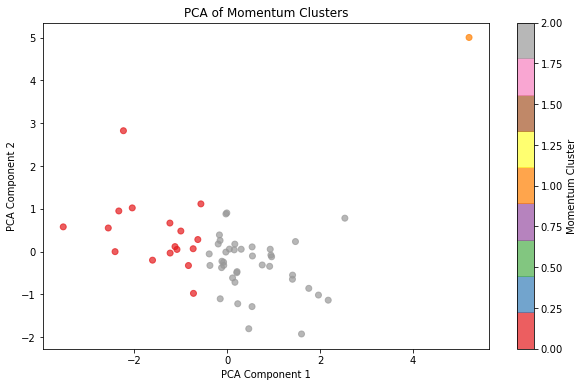

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_features["momentum_cluster"], cmap='Set1', alpha=0.7)
plt.title("PCA of Momentum Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Momentum Cluster')
plt.show()


                   trading_frequency  avg_volume  zero_volume_ratio  \
trading_frequency           1.000000    0.187465          -1.000000   
avg_volume                  0.187465    1.000000          -0.187465   
zero_volume_ratio          -1.000000   -0.187465           1.000000   
mean_return                -0.512275   -0.062431           0.512275   
volatility_7d               0.231514   -0.202780          -0.231514   
volatility_30d              0.163931   -0.209254          -0.163931   
max_drawdown               -0.257761   -0.191938           0.257761   
momentum_30d                0.260409    0.162118          -0.260409   
std_return                 -0.660152   -0.293447           0.660152   

                   mean_return  volatility_7d  volatility_30d  max_drawdown  \
trading_frequency    -0.512275       0.231514        0.163931     -0.257761   
avg_volume           -0.062431      -0.202780       -0.209254     -0.191938   
zero_volume_ratio     0.512275      -0.231514       

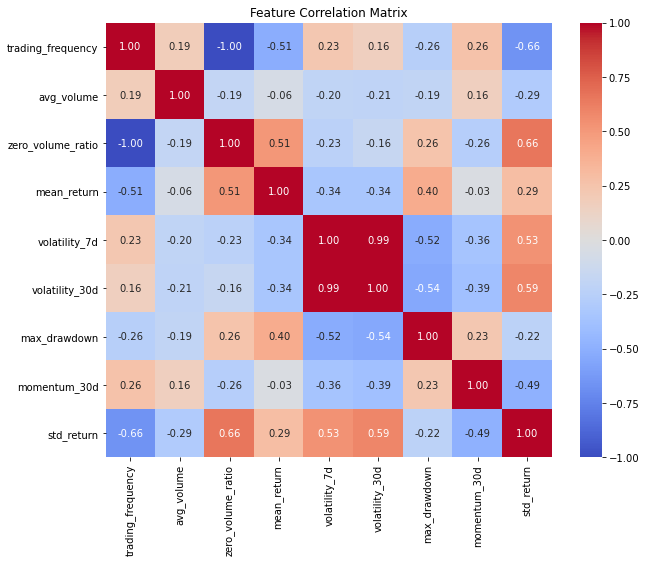

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataset is in a DataFrame called df
# Select only the feature columns
features_df = df_features[[
    "trading_frequency",
    "avg_volume",
    "zero_volume_ratio",
    "mean_return",
    "volatility_7d",
    "volatility_30d",
    "max_drawdown",
    "momentum_30d",
    "std_return"
]]

# Compute the correlation matrix
corr_matrix = features_df.corr()

# Print correlation matrix
print(corr_matrix)

# Visualize correlation with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()


In [60]:
'''
df["screen_score"] = (
    df["momentum_30d"].rank(pct=True) * 0.4
    + df["mean_return"].rank(pct=True) * 0.3
    - df["volatility_30d"].rank(pct=True) * 0.2
    - df["max_drawdown"].rank(pct=True) * 0.1
)
'''

'\ndf["screen_score"] = (\n    df["momentum_30d"].rank(pct=True) * 0.4\n    + df["mean_return"].rank(pct=True) * 0.3\n    - df["volatility_30d"].rank(pct=True) * 0.2\n    - df["max_drawdown"].rank(pct=True) * 0.1\n)\n'

###### 


In [61]:
'''
print(df_features.groupby("liq_kmeans")[features].mean())
print('---------------------------------------------')
print(df_features.groupby("liq_dbscan")[features].mean())
print('---------------------------------------------')
print(df_features.groupby("liq_agg")[features].mean())
print('---------------------------------------------')
print(df_features.groupby("liq_gmm")[features].mean())
'''


'\nprint(df_features.groupby("liq_kmeans")[features].mean())\nprint(\'---------------------------------------------\')\nprint(df_features.groupby("liq_dbscan")[features].mean())\nprint(\'---------------------------------------------\')\nprint(df_features.groupby("liq_agg")[features].mean())\nprint(\'---------------------------------------------\')\nprint(df_features.groupby("liq_gmm")[features].mean())\n'

In [62]:
df = pd.read_csv('./Data/NSE_data_cleaned.csv')
df.drop(columns=['Adjusted Price'], inplace=True)
df

FileNotFoundError: [Errno 2] No such file or directory: './Data/NSE_data_cleaned.csv'

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(["Code", "Date"])
df.head(10)

,Date,Code,Name,12m Low,12m High,Day Low,Day High,Day Price,Previous,Change,% Change,Volume,Sector
7,2021-01-04,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.42,9.80,9.52,9.66,-0.14,1.45,18500.0,Banking
78,2021-01-05,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.70,9.44,9.52,-0.08,0.84,1923300.0,Banking
149,2021-01-06,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.40,9.68,9.44,9.44,0.00,0.00,233400.0,Banking
220,2021-01-07,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.36,9.46,9.40,9.44,-0.04,0.42,194700.0,Banking
291,2021-01-11,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.70,9.46,9.48,-0.02,0.21,77900.0,Banking
362,2021-01-12,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.70,9.50,9.46,0.04,0.42,40200.0,Banking
433,2021-01-13,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.38,9.78,9.42,9.50,-0.08,0.84,583000.0,Banking
504,2021-01-14,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.40,9.50,9.40,9.42,-0.02,0.21,195400.0,Banking
575,2021-01-15,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.78,9.50,9.40,0.10,1.06,56100.0,Banking
646,2021-01-18,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.76,9.50,9.50,0.00,0.00,148100.0,Banking


In [ ]:
g = df.groupby("Code", group_keys=False)

# basic returns
df["return_1d"] = g["Day Price"].pct_change()

# intraday range (volatility proxy)
df["range_pct"] = (df["Day High"] - df["Day Low"]) / df["Day Price"]

# rolling features
df["ret_5d"]  = g["return_1d"].rolling(5).mean().reset_index(level=0, drop=True)
df["ret_10d"] = g["return_1d"].rolling(10).mean().reset_index(level=0, drop=True)

df["vol_5d"]  = g["return_1d"].rolling(5).std().reset_index(level=0, drop=True)
df["vol_10d"] = g["return_1d"].rolling(10).std().reset_index(level=0, drop=True)

# rolling volume
df["volu_5d"] = g["Volume"].rolling(5).mean().reset_index(level=0, drop=True)


In [ ]:
df["tomorrow"] = g["Day Price"].shift(-1)

df["target"] = (df["tomorrow"] > df["Day Price"]).astype(int)
df.head(10)

,Date,Code,Name,12m Low,12m High,Day Low,Day High,Day Price,Previous,Change,...,Sector,return_1d,range_pct,ret_5d,ret_10d,vol_5d,vol_10d,volu_5d,tomorrow,target
7,2021-01-04,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.42,9.80,9.52,9.66,-0.14,...,Banking,NaN,0.039916,NaN,NaN,NaN,NaN,NaN,9.44,0
78,2021-01-05,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.70,9.44,9.52,-0.08,...,Banking,-0.008403,0.027542,NaN,NaN,NaN,NaN,NaN,9.44,0
149,2021-01-06,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.40,9.68,9.44,9.44,0.00,...,Banking,0.000000,0.029661,NaN,NaN,NaN,NaN,NaN,9.40,0
220,2021-01-07,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.36,9.46,9.40,9.44,-0.04,...,Banking,-0.004237,0.010638,NaN,NaN,NaN,NaN,NaN,9.46,1
291,2021-01-11,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.70,9.46,9.48,-0.02,...,Banking,0.006383,0.027484,NaN,NaN,NaN,NaN,489560.0,9.50,1
362,2021-01-12,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.70,9.50,9.46,0.04,...,Banking,0.004228,0.027368,-0.000406,NaN,0.006049,NaN,493900.0,9.42,0
433,2021-01-13,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.38,9.78,9.42,9.50,-0.08,...,Banking,-0.008421,0.042463,-0.000409,NaN,0.006055,NaN,225840.0,9.40,0
504,2021-01-14,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.40,9.50,9.40,9.42,-0.02,...,Banking,-0.002123,0.010638,-0.000834,NaN,0.006093,NaN,218240.0,9.50,1
575,2021-01-15,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.78,9.50,9.40,0.10,...,Banking,0.010638,0.035789,0.002141,NaN,0.007488,NaN,190520.0,9.50,0
646,2021-01-18,ABSA,ABSA Bank Kenya Plc,8.5,14.2,9.44,9.76,9.50,9.50,0.00,...,Banking,0.000000,0.033684,0.000864,NaN,0.007119,NaN,204560.0,9.50,0


In [ ]:
df = df[~df["Code"].str.startswith("^")]


In [ ]:
df.dropna(inplace=True)

<ipython-input-77-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
feature_cols = [
    "return_1d",
    "range_pct",
    "ret_5d",
    "ret_10d",
    "vol_5d",
    "vol_10d",
    "volu_5d"
]

df_model = df.dropna(subset=feature_cols + ["target"])


In [ ]:
X_num = df_model[feature_cols]
X_cat = df_model[["Sector"]]

y = df_model["target"]


In [ ]:
split_date = df_model["Date"].quantile(0.8)

train_idx = df_model["Date"] <= split_date
test_idx  = df_model["Date"] > split_date

X_num_train = X_num[train_idx]
X_num_test  = X_num[test_idx]

X_cat_train = X_cat[train_idx]
X_cat_test  = X_cat[test_idx]

y_train = y[train_idx]
y_test  = y[test_idx]


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["Sector"])
    ]
)

model = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])
model.fit(
    pd.concat([X_num_train, X_cat_train], axis=1),
    y_train
)

from sklearn.metrics import classification_report

pred = model.predict(
    pd.concat([X_num_test, X_cat_test], axis=1)
)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.72      0.93      0.81      8867
           1       0.50      0.16      0.24      3871

    accuracy                           0.70     12738
   macro avg       0.61      0.54      0.53     12738
weighted avg       0.65      0.70      0.64     12738

